<a href="https://colab.research.google.com/github/samindelhi/CNN-Exercises/blob/main/InceptionV3_TransferLearning_Flowers_Corrected.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inception V3, Transfer Learning with Flowers Dataset
This notebook demonstrates how to perform transfer learning using InceptionV3 in keras with a multi-class flowers RGB dataset.


In [1]:
!nvidia-smi


Wed Oct 15 14:20:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   55C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
! pip install tensorflow matplotlib split-folders -q

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [4]:
# Download and unzip dataset
!wget https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
!mkdir -p ./flowers_dataset
!tar -xvzf flower_photos.tgz -C ./flowers_dataset


--2025-10-15 14:20:53--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.98.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.98.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘flower_photos.tgz’

flower_photos.tgz   100%[===================>] 218.21M   233MB/s    in 0.9s    

2025-10-15 14:20:54 (233 MB/s) - ‘flower_photos.tgz’ saved [228813984/228813984]

flower_photos/
flower_photos/roses/
flower_photos/roses/14810868100_87eb739f26_m.jpg
flower_photos/roses/1446090416_f0cad5fde4.jpg
flower_photos/roses/15319767030_e6c5602a77_m.jpg
flower_photos/roses/15032112248_30c5284e54_n.jpg
flower_photos/roses/7211616670_2d49ecb3a5_m.jpg
flower_photos/roses/15674450867_0ced942941_n.jpg
flower_photos/roses/17158274118_00ec99a23c.jpg
flower_

In [5]:
# split flowers
import splitfolders
splitfolders.ratio("flowers_dataset/flower_photos", output="flowers_split", seed=42, ratio=(.7, .2, .1))


Copying files: 3670 files [00:00, 5582.05 files/s]


In [6]:
IMG_SIZE = (299,299)
BATCH_SIZE = 64

#Data Augmentation.
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   rotation_range=30, zoom_range=0.2,
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
test_datagen =ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    'flowers_split/train', target_size = IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
val_generator = train_datagen.flow_from_directory(
    'flowers_split/val', target_size = IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical')
test_generator = train_datagen.flow_from_directory(
    'flowers_split/test', target_size = IMG_SIZE, batch_size=BATCH_SIZE, class_mode='categorical', shuffle=False)





Found 2567 images belonging to 5 classes.
Found 731 images belonging to 5 classes.
Found 372 images belonging to 5 classes.


In [20]:
# Load InceptionV3 and add custom laers
from tensorflow import keras

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(299,299,3))

# making the base_model layers non-trainable. Only training the top layers below.
for layer in base_model.layers:
  layer.trainable= False

x= base_model.output
x= GlobalAveragePooling2D()(x)
x= Dense(1024, activation='relu')(x)
predictions= Dense(train_generator.num_classes, activation='softmax')(x)

inputs = base_model.outputs

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 299, 299,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1222         │ (None, 149, 149,  │        864 │ input_layer_13[0… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 149, 149,  │         96 │ conv2d_1222[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1222     │ (None, 149, 149,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1223         │ (None, 147, 147,  │      9,216 │ activation_1222[… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │         96 │ conv2d_1223[0][0] │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1223     │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1224         │ (None, 147, 147,  │     18,432 │ activation_1223[… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 147, 147,  │        192 │ conv2d_1224[0][0] │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1224     │ (None, 147, 147,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_52    │ (None, 73, 73,    │          0 │ activation_1224[… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1225         │ (None, 73, 73,    │      5,120 │ max_pooling2d_52… │
│ (Conv2D)            │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 73, 73,    │        240 │ conv2d_1225[0][0] │
│ (BatchNormalizatio… │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1225     │ (None, 73, 73,    │          0 │ batch_normalizat… │
│ (Activation)        │ 80)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1226         │ (None, 71, 71,    │    138,240 │ activation_1225[… │
│ (Conv2D)            │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 71, 71,    │        576 │ conv2d_1226[0][0] │
│ (BatchNormalizatio… │ 192)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1226     │ (None, 71, 71,    │          0 │ batch_normalizat

 Total params: 23,906,085 (91.19 MB)

 Trainable params: 2,103,301 (8.02 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [21]:
history = model.fit(train_generator, epochs=10, validation_data=val_generator)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 120s 2s/step - accuracy: 0.5267 - loss: 1.1673 - val_accuracy: 0.8222 - val_loss: 0.5560
Epoch 2/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.8475 - loss: 0.4633 - val_accuracy: 0.8399 - val_loss: 0.4545
Epoch 3/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.8583 - loss: 0.4110 - val_accuracy: 0.8577 - val_loss: 0.3904
Epoch 4/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 80s 2s/step - accuracy: 0.9064 - loss: 0.3053 - val_accuracy: 0.8468 - val_loss: 0.3904
Epoch 5/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9065 - loss: 0.2946 - val_accuracy: 0.8782 - val_loss: 0.3457
Epoch 6/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9243 - loss: 0.2387 - val_accuracy: 0.8687 - val_loss: 0.3614
Epoch 7/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 69s 2s/step - accuracy: 0.9160 - loss: 0.2556 - val_accuracy: 0.8687 - val_loss: 0.3488
Epoch 8/10
41/41 ━━━━━━━━━━━━━━━━━━━━ 70s 2s/step - accuracy: 0.9304 - loss: 0.2306 - val_accuracy: 0.8782 - val_loss

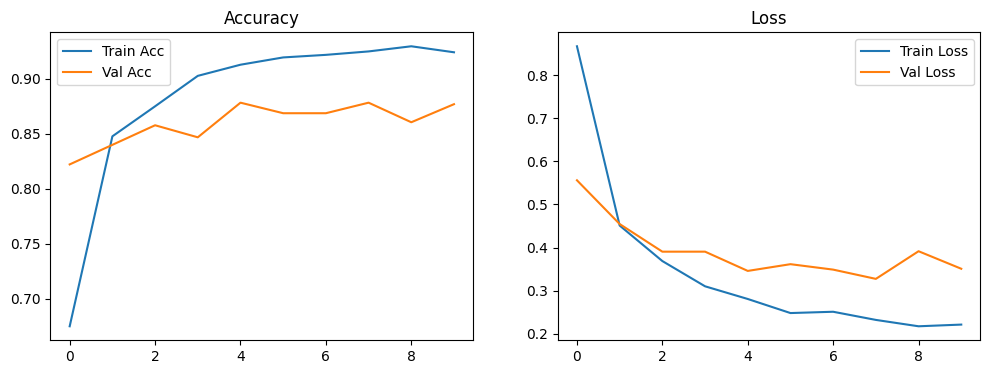

In [22]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.legend()
plt.title('Accuracy')

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('Loss')
plt.show()


In [23]:
loss, acc = model.evaluate(test_generator)
print(f"Test Accuracy: {acc:.4f}")

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


6/6 ━━━━━━━━━━━━━━━━━━━━ 24s 5s/step - accuracy: 0.9042 - loss: 0.2695
Test Accuracy: 0.8656


In [26]:
from tensorflow.keras.preprocessing import image
def predict_image(img_path):
  img = image.load_img(img_path, target_size=IMG_SIZE)
  img_array = image.img_to_array(img)
  img_array = preprocess_input(img_array)
  img_array = np.expand_dims(img_array, axis=0)

  preds = model.predict(img_array)
  class_index = np.argmax(preds)
  class_label = list(train_generator.class_indices.keys())[class_index]
  print(f"Prediction: {class_label} ({preds[0] [class_index] * 100:.2f}%)")
  plt.imshow(img)  # Use the loaded image for visualization
  plt.axis('off') #hide axes
  plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Prediction: roses (96.20%)


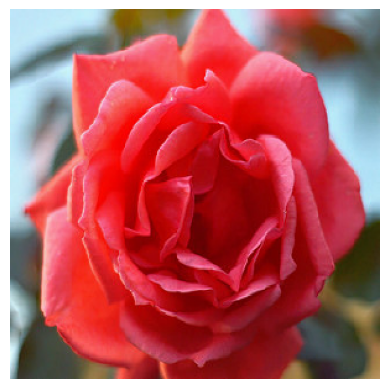

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
Prediction: dandelion (80.82%)


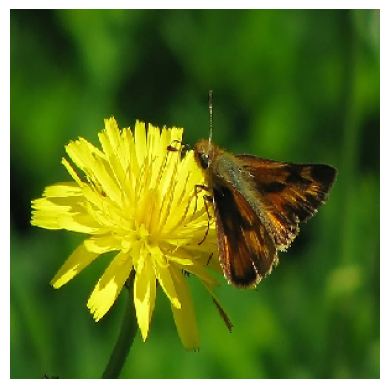

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
Prediction: daisy (97.11%)


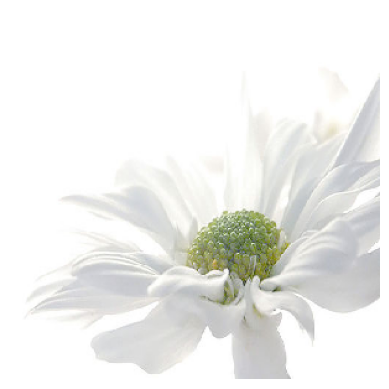

In [29]:
predict_image("/content/flowers_split/test/roses/15498482197_8878cdfb07_n.jpg")
predict_image("/content/flowers_split/test/dandelion/1241011700_261ae180ca.jpg")
predict_image("/content/flowers_split/test/daisy/11642632_1e7627a2cc.jpg")